In [91]:
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [60]:
DATE = 'date'
CLOSE_PRICE = 'close'

### Reading Data from Product Demand Sample Data file and Filtering by One Product

In [61]:
df = pd.read_csv('data/GOOG.csv' ,encoding='utf-8',nrows=100000)

df[DATE]= pd.to_datetime(df[DATE]) 
df.head()
df = df.set_index(DATE)
df = df.sort_index()
df.head(10)

,volume,open,close,high,low,adjclose
date,,,,,,
2004-08-19,44994500,49.676899,49.845802,51.693783,47.669952,49.845802
2004-08-20,23005800,50.178635,53.805050,54.187561,49.925285,53.805050
2004-08-23,18393200,55.017166,54.346527,56.373344,54.172661,54.346527
2004-08-24,15361800,55.260582,52.096165,55.439419,51.450363,52.096165
2004-08-25,9257400,52.140873,52.657513,53.651051,51.604362,52.657513
2004-08-26,7148200,52.135906,53.606342,53.626213,51.991844,53.606342
2004-08-27,6258300,53.700729,52.732029,53.959049,52.503513,52.732029
2004-08-30,5235700,52.299839,50.675404,52.404160,50.675404,50.675404
2004-08-31,4954800,50.819469,50.854240,51.519913,50.749920,50.854240


### Coverting into a univariate timeseries data

In [62]:
df = df[[CLOSE_PRICE]]
df[CLOSE_PRICE] =  df[CLOSE_PRICE].astype('float64')
df.head(10)
complete_df = df

### only picking up starting of months

In [63]:
df = df[df.index.day == 1]

In [64]:
len(df)

115

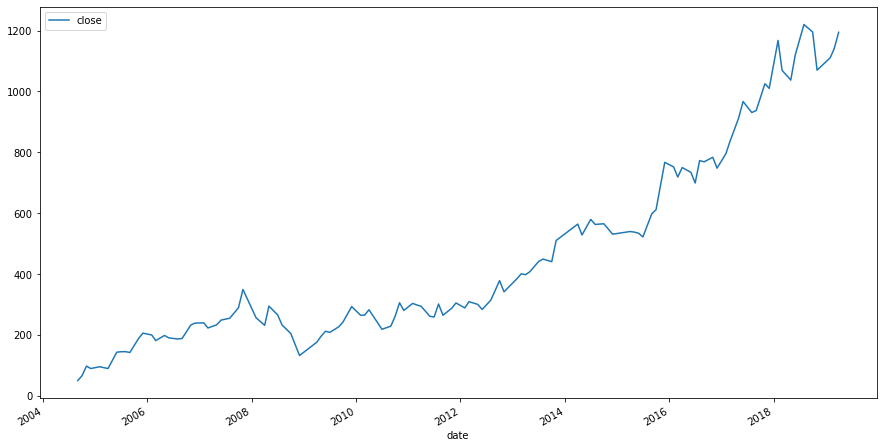

In [65]:
df.plot(use_index=True,figsize=(15,8))

In [38]:
# transform scale
X = df.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_X[-10:]

array([[0.91059706],
       [0.74279808],
       [0.68774815],
       [0.82821869],
       [1.        ],
       [0.9577854 ],
       [0.74361841],
       [0.8132641 ],
       [0.86494716],
       [0.95628139]])

In [39]:
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_X[-10:]

array([[1167.69995117],
       [1069.52001953],
       [1037.31005859],
       [1119.5       ],
       [1220.01000977],
       [1195.31005859],
       [1070.        ],
       [1110.75      ],
       [1140.98999023],
       [1194.43005371]])

### Split Data Set into Sequences for input

In [40]:
def split_sequences(data,input_size, output_size=1):
    df = DataFrame(data)
    cols = list()
    for i in range(input_size, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, output_size):
        cols.append(df.shift(-i))

    agg = concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

#split the dataset into train and test
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

#measure error
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [41]:
# Caluculating difference between two lag data points , where order tells the distance between them 
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]


In [42]:
# create a differenced series
# def difference(dataset, interval=1):
#     diff = list()
#     for i in range(interval, len(dataset)):
#         value = dataset[i] - dataset[i - interval]
#         diff.append(value)
#     return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

###  Model Definition

In [43]:
def model_fit(train_data, config):
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # n_diff tells us to consider the training set which just tells the difference between historical data points
    if n_diff > 0:
        train = difference(train_data, n_diff)
        
    data = split_sequences(train, input_size=n_input)
    # From the split sequences function the last piece is always the univariate output that we want. 
    train_x, train_y = data[:, :-1], data[:, -1]
    #number of output features
    n_features = 1
    # Convert the input data into 3D array as input for the neural net
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # Model Architecture
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # we can set verbose to 1, if we want to see the output
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

### Predict Single Step

In [44]:
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    correction = 0.0
    #convert back the differenced data into its orginal form
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    #model can only pick up input in form of the nueral net structure
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    forecast = model.predict(x_input, verbose=0)
    return correction + forecast[0]

### Walk Forward

In [45]:
def walk_forward(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        prediction = model_predict(model, history, cfg)
        predictions.append(prediction)
        history.append(test[i])
    return test,predictions

def walk_forward_validation(data, n_test, cfg):
    test, predictions = walk_forward(data, n_test, cfg)
    # estimate prediction error
    error = rmse(test, predictions)
    print(' > %.3f' % error)
    return error

def walk_forward_visualization(data,n_test,cfg):
    print(cfg)
    test, predictions = walk_forward(data, n_test, cfg)
    # Plot to visualize actual vs predicted
    plt.figure(figsize=(15,8))
    plt.plot(test, label='actual_data')
    plt.plot(predictions, label='predicted_data')
    plt.legend()
    plt.show()

### Design Grid Search System

In [111]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    scores.sort(key=lambda tup: tup[1])
    return scores
#defininig all the hyper parameters
def model_configs():
    n_input = [1,3,6]
    n_nodes = [8,16]
    n_epochs = [10,100]
    n_batch = [16,32]
    n_diff = [1]
    # create configs
    #try all the configurations using grid search
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

### Overlay monthly predictions with daily activity

In [112]:
def monthly_test_daily_overview(test_month_start,test_month_end):
    return df.loc[test_month_start:]
#     print(datetime.strptime(test_month_start,'%Y-%m-%d').date())
#     print(df.index)
#     return df[df.index == datetime.strptime(test_month_start,'%Y-%m-%d').date()]
        
    

In [113]:
monthly_test_daily_overview('2019-01-01','2019-01-02')

,close
date,
2019-02-01,1110.750000
2019-03-01,1140.989990
2019-04-01,1194.430054


### Kick off Grid Search    

In [114]:
n_test = 20
# model configs
data = scaled_X
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('grid search done')
# list top 3 configs to visualize
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 24
 > 0.117
 > 0.116
 > 0.116
 > 0.116
 > 0.116
 > 0.115
 > 0.116
 > 0.117
 > 0.115
 > 0.115
> Model[[1, 8, 10, 16, 1]] 0.116
 > 0.116
 > 0.116
 > 0.116
 > 0.116
 > 0.117
 > 0.115
 > 0.116
 > 0.116
 > 0.116
 > 0.116
> Model[[1, 8, 10, 32, 1]] 0.116
 > 0.116
 > 0.116
 > 0.117
 > 0.116
 > 0.116
 > 0.116
 > 0.116
 > 0.117
 > 0.117
 > 0.115
> Model[[1, 8, 100, 16, 1]] 0.116
 > 0.116
 > 0.115
 > 0.115
 > 0.116
 > 0.116
 > 0.115
 > 0.116
 > 0.116
 > 0.116
 > 0.116
> Model[[1, 8, 100, 32, 1]] 0.116
 > 0.116
 > 0.117
 > 0.116
 > 0.115
 > 0.116
 > 0.116
 > 0.116
 > 0.116
 > 0.116
 > 0.115
> Model[[1, 16, 10, 16, 1]] 0.116
 > 0.116
 > 0.116
 > 0.116
 > 0.116
 > 0.116
 > 0.117
 > 0.116
 > 0.117
 > 0.116
 > 0.116
> Model[[1, 16, 10, 32, 1]] 0.116
 > 0.114
 > 0.115
 > 0.116
 > 0.115
 > 0.115
 > 0.116
 > 0.116
 > 0.116
 > 0.116
 > 0.115
> Model[[1, 16, 100, 16, 1]] 0.115
 > 0.116
 > 0.115
 > 0.116
 > 0.116
 > 0.115
 > 0.115
 > 0.115
 > 0.116
 > 0.116
 > 0.115
> Model[[1, 16, 100, 32, 

[3, 16, 100, 32, 1]


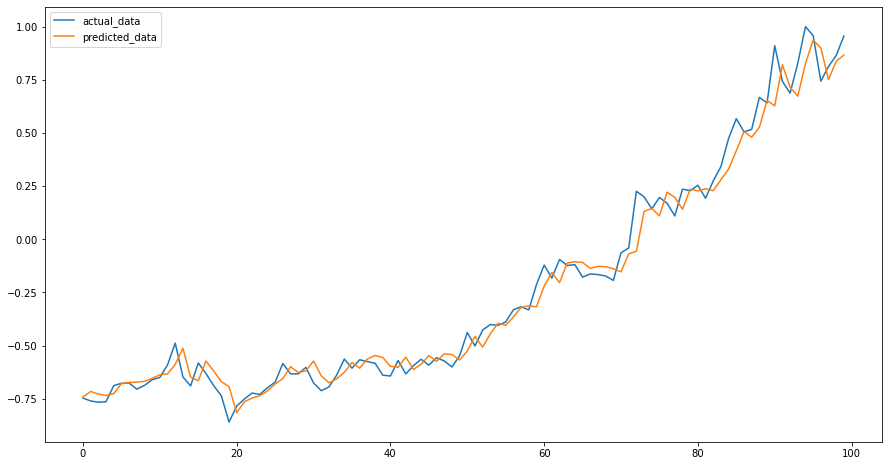

In [51]:
walk_forward_visualization(scaled_X, 100, [3, 16, 100, 32, 1])

In [57]:
monthly_test_daily_overview('2019-01-01','2019-01-02')

UnboundLocalError: local variable 'df' referenced before assignment